In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
import re
import yfinance as yf
import seaborn as sns

%matplotlib inline
warnings.simplefilter('ignore')


In [152]:
pd.__version__

'2.0.2'

## Use yfinance  to load Tesla Stock prices 
### From 1st Jan 2020 to 31st May 2023

In [4]:
ticker = 'TSLA'
start_date = '2020-01-01'
end_date = '2023-05-31'

# check wheter data is available
data = yf.Ticker(ticker).history(start=start_date, end=end_date)

if data.empty:
    print('No data for the specified range')
else:
    print('Data available for the specified range')

Data available for the specified range


In [5]:
tesla = yf.download(ticker, start=start_date, end=end_date)
tesla.head()

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2020-01-02,28.299999,28.713333,28.114000,28.684000,28.684000,142981500
2020-01-03,29.366667,30.266666,29.128000,29.534000,29.534000,266677500
2020-01-06,29.364668,30.104000,29.333332,30.102667,30.102667,151995000
2020-01-07,30.760000,31.441999,30.224001,31.270666,31.270666,268231500
2020-01-08,31.580000,33.232666,31.215334,32.809334,32.809334,467164500


## Exploratory Data Analysis
### Understand the data before deploying any further analysis efforts

In [6]:
# Check data types
tesla.dtypes

Open         float64
High         float64
Low          float64
Close        float64
Adj Close    float64
Volume         int64
dtype: object

In [126]:
tesla.index

DatetimeIndex(['2020-01-02', '2020-01-03', '2020-01-06', '2020-01-07',
               '2020-01-08', '2020-01-09', '2020-01-10', '2020-01-13',
               '2020-01-14', '2020-01-15',
               ...
               '2023-05-16', '2023-05-17', '2023-05-18', '2023-05-19',
               '2023-05-22', '2023-05-23', '2023-05-24', '2023-05-25',
               '2023-05-26', '2023-05-30'],
              dtype='datetime64[ns]', name='Date', length=858, freq=None)

<Axes: xlabel='Open', ylabel='Density'>

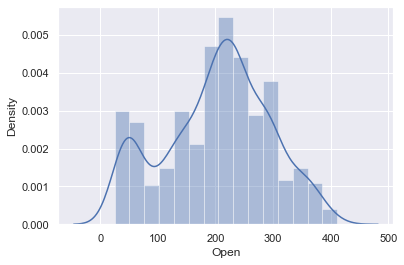

In [121]:
# Open price distribution
sns.distplot(tesla.Open)

<Axes: xlabel='Low', ylabel='Density'>

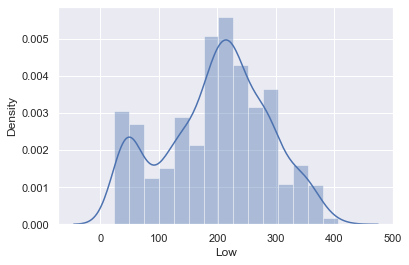

In [122]:
# Low price distribution
sns.distplot(tesla.Low)

<Axes: xlabel='High', ylabel='Density'>

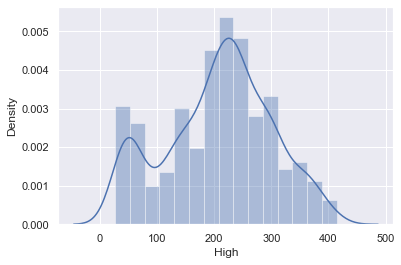

In [123]:
# High price distribution
sns.distplot(tesla.High)

<Axes: xlabel='Close', ylabel='Density'>

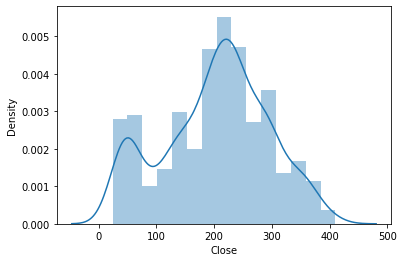

In [7]:
# Close price distribution
sns.distplot(tesla.Close)

In [8]:
tesla.Close.describe()

count    858.000000
mean     202.626794
std       90.972516
min       24.081333
25%      141.182495
50%      214.450005
75%      266.862503
max      409.970001
Name: Close, dtype: float64

In [36]:
# get year
X_year = tesla.index.year
X_year = np.reshape(X_year, (-1, 1))
# get the month
X_month = tesla.index.month  
X_month = np.reshape(X_month, (-1, 1))
# the hour
X_hour = tesla.index.hour
X_hour = np.reshape(X_hour, (-1, 1))
# day of the week
X_dayofweek = tesla.index.dayofweek
X_dayofweek = np.reshape(X_dayofweek, (-1, 1))
# create the feature
X = np.hstack([X_year, X_month, X_dayofweek])
# get the target (close price)
y = tesla.Close

In [75]:
X_df = pd.DataFrame(X, columns=['Year', 'Month', 'Day'])
slice_df = tesla[['Volume', 'Low', 'High', 'Open', 'Close']]
slice_df = slice_df.reset_index(None)
slice_df = slice_df.drop(columns='Date')
slice_inspect_df = pd.concat([X_df, slice_df], axis=1)
slice_inspect_df.head()

,Year,Month,Day,Volume,Low,High,Open,Close
0,2020,1,3,142981500,28.114000,28.713333,28.299999,28.684000
1,2020,1,4,266677500,29.128000,30.266666,29.366667,29.534000
2,2020,1,0,151995000,29.333332,30.104000,29.364668,30.102667
3,2020,1,1,268231500,30.224001,31.441999,30.760000,31.270666
4,2020,1,2,467164500,31.215334,33.232666,31.580000,32.809334


<Axes: >

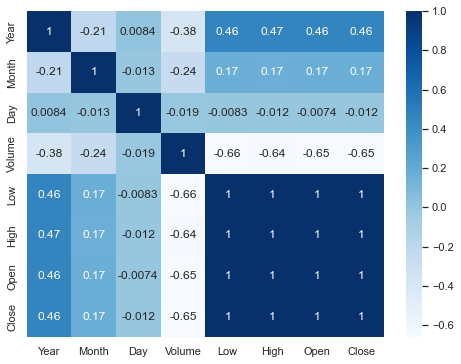

In [76]:
# Create a correlation heatmap 
plt.figure(figsize=(8,6))
sns.heatmap(slice_inspect_df.corr(), annot=True, cmap='Blues')

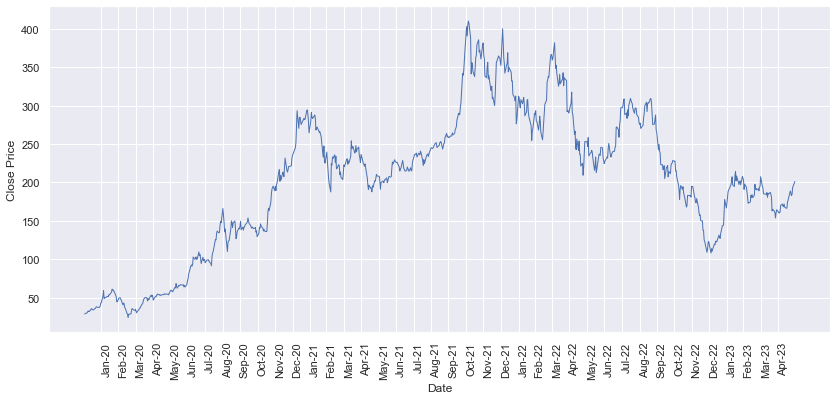

In [127]:
plt.figure(figsize=(14, 6))
sns.set()

xticks = pd.date_range(start=tesla.index.min(), end=tesla.index.max(), freq='M')
plt.plot(tesla.Close, linewidth=1)
plt.xticks(xticks, xticks.strftime("%b-%y"), rotation=90, ha='left')
plt.xlabel('Date')
plt.ylabel('Close Price');

## Data Cleaning
### Act on any anonalies in the data

In [124]:
tesla.isna().value_counts()

Open   High   Low    Close  Adj Close  Volume
False  False  False  False  False      False     858
Name: count, dtype: int64

## Feature Engineering
### Finding a better way to represent our features

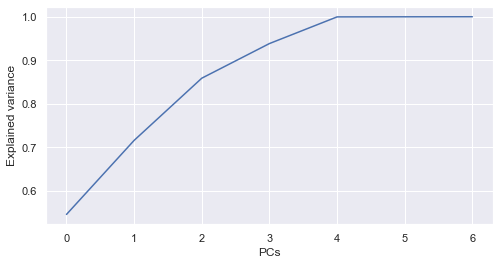

In [130]:
# PCA for Dimensionality Reduction
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

features_X = slice_inspect_df.drop(columns='Close')

pca = PCA()
scaler = StandardScaler()
scaler.fit(features_X)
tesla_df_scaled = scaler.transform(features_X)
pca.fit(tesla_df_scaled)

plt.figure(figsize=(8,4))
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.ylabel('Explained variance')
plt.xlabel('PCs');

In [131]:
# Check which are these 4 features that explain 100% of variations
pcs = pca.components_.shape[0]
important = [np.abs(pca.components_[i]).argmax() for i in range(pcs)]
most_important = [tesla_df.columns[important[i]] for i in range(pcs)]
dic = {'PC{}'.format(i+1): most_important[i] for i in range(pcs)}
important_df = pd.DataFrame(sorted(dic.items()), columns=['PC', 'Feature'])
important_df

,PC,Feature
0,PC1,Low
1,PC2,Month
2,PC3,Day
3,PC4,Year
4,PC5,Volume
5,PC6,Low
6,PC7,High


In [132]:
# poly features
from sklearn.preprocessing import PolynomialFeatures, StandardScaler

scaler = StandardScaler()
poly = PolynomialFeatures(degree=2, include_bias=False)

scaler.fit(features_X)
X_scaled = scaler.transform(features_X)
poly.fit(X_scaled)
X_scaled_poly = poly.transform(X_scaled)
print('Initial features shape: ', features_X.shape)
print('Polynomial features shape: ', X_scaled_poly.shape)
print('Feature names: \n', poly.get_feature_names())

Initial features shape:  (858, 7)
Polynomial features shape:  (858, 35)
Feature names: 
 ['x0', 'x1', 'x2', 'x3', 'x4', 'x5', 'x6', 'x0^2', 'x0 x1', 'x0 x2', 'x0 x3', 'x0 x4', 'x0 x5', 'x0 x6', 'x1^2', 'x1 x2', 'x1 x3', 'x1 x4', 'x1 x5', 'x1 x6', 'x2^2', 'x2 x3', 'x2 x4', 'x2 x5', 'x2 x6', 'x3^2', 'x3 x4', 'x3 x5', 'x3 x6', 'x4^2', 'x4 x5', 'x4 x6', 'x5^2', 'x5 x6', 'x6^2']


## Model Selection
### Inspect different models and select the one that performs best

In [95]:
n_train = 686 # 686 days (80%) of the data range as the training set


# define a function to evaluate different models performances
def evaluate_model(features, target, model):
    X_train, X_test = features[:n_train], features[n_train:]
    y_train, y_test = target[:n_train], target[n_train:]
    model.fit(X_train, y_train)
    print('Train set score: {:.3f}'.format(model.score(X_train, y_train)))
    print('Test set score: {:.3f}'.format(model.score(X_test, y_test)))
    
    pred_train = model.predict(X_train)
    pred_test = model.predict(X_test)
    
    plt.figure(figsize=(14, 6))
    plt.plot(range(n_train), y_train, label='Train-set')
    plt.plot(range(n_train), pred_train, '--', color='m', label='Predicted Train-set')
    plt.plot(range(n_train, len(y_test)+n_train), y_test, label='Test-set')
    plt.plot(range(n_train, len(y_test)+n_train), pred_test, '--', label='Predicted Test-set')
    plt.xticks(range(0, len(X)+16, 22), xticks.strftime("%b-%y"), rotation=90, ha='left')
    plt.ylabel('Close Price')
    plt.xlabel('Date')
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))


Train set score: 0.999
Test set score: 0.994


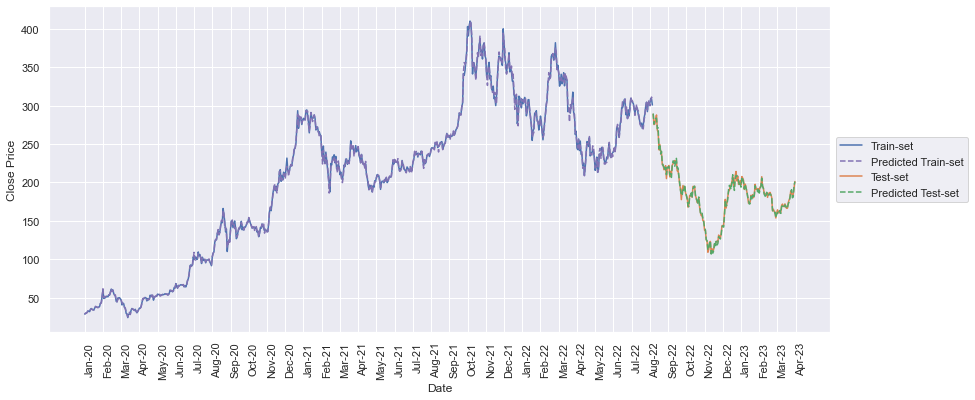

In [96]:
# Linear Regression without Polynomial features
from sklearn.linear_model import LinearRegression

lr = LinearRegression()
evaluate_model(features_X, y, lr)

Train set score: 0.987
Test set score: 0.650


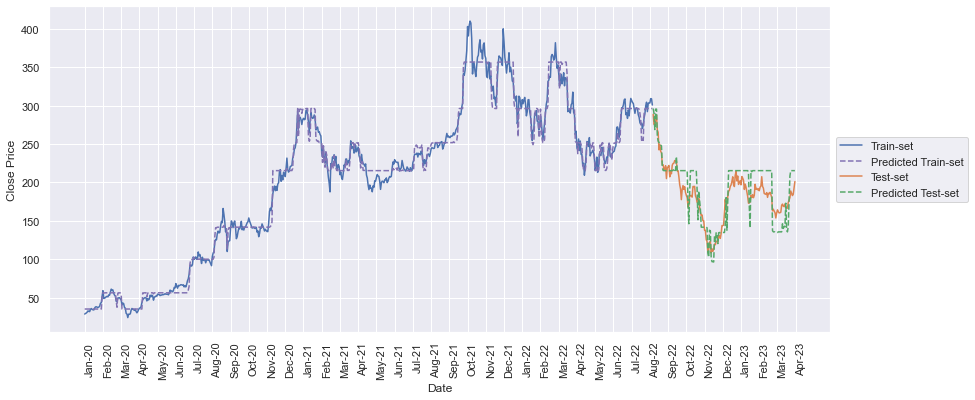

In [97]:
# random forest without polynomial features
from sklearn.ensemble import RandomForestRegressor

forest = RandomForestRegressor(random_state=42, max_depth=3)
evaluate_model(features_X, y, forest)

Train set score: 0.999
Test set score: 0.973


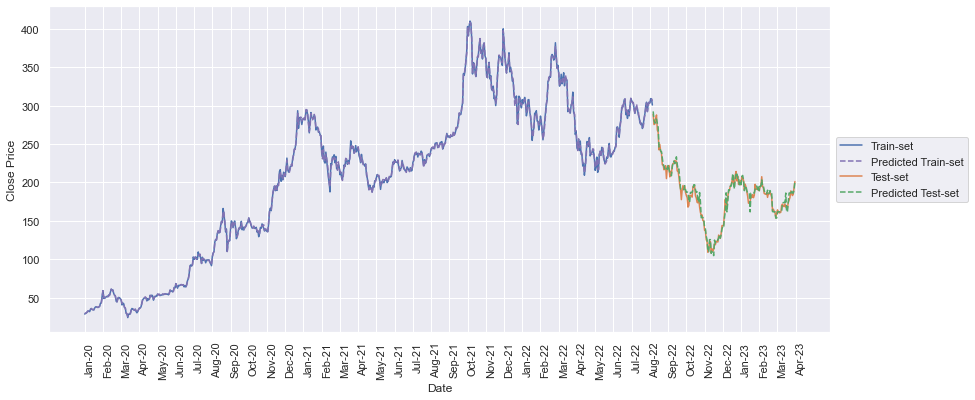

In [98]:
# gradient boosting without polynomial features
from sklearn.ensemble import GradientBoostingRegressor

gbr = GradientBoostingRegressor()
evaluate_model(features_X, y, gbr)

Train set score: 0.999
Test set score: 0.971


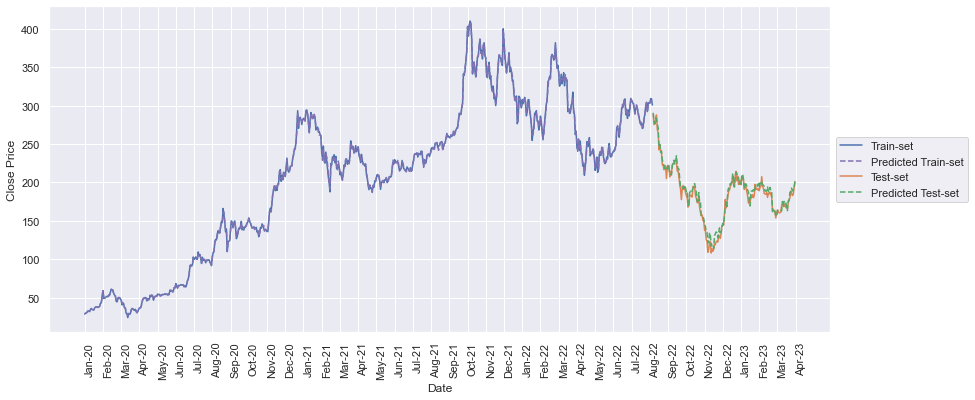

In [116]:
# gradient booting regressor with polynomials
evaluate_model(X_scaled_poly, y, gbr)

### Select only those features that are relevant using a percentile threshold

In [109]:
# feature selection using univariate statistics
from sklearn.feature_selection import SelectPercentile
from sklearn.model_selection import train_test_split

# split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled_poly, y, random_state=0)

# create an instance of feature selection
select = SelectPercentile(percentile=50)
select.fit(X_train, y_train)
X_train_selected = select.transform(X_train)
print('Selected features shape: ', X_train_selected.shape)

Selected features shape:  (643, 17)


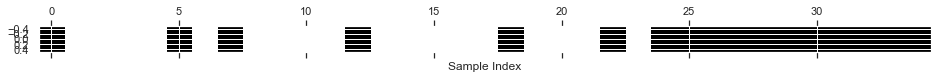

In [114]:
# visualize the selected features
mask = select.get_support()
plt.matshow(mask.reshape(1, -1), cmap='gray_r')
plt.xlabel('Sample Index');

### HyperParameter Tuning for Gradient Boositng Regressor using RandomizedSearchCV

In [104]:
# number of boosting stages
n_estimators = [int(x) for x in np.linspace(start=100, stop=1000, num=10)]

# each tree contribution to final prediction
learning_rate = [0.01, 0.1, 1]

# maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num=11)]

# minimum number of samples required to split an internal node
min_samples_split = [2, 5, 10]

# minimum number of samples required to be a leaf node
min_samples_leaf = [1, 2, 4]

# number of features to consider when looking at the best split at each node
max_features = ['auto', 'sqrt']

random_grid = {'n_estimators': n_estimators,
               'learning_rate': learning_rate,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'max_features': max_features}
               

In [117]:
from sklearn.model_selection import RandomizedSearchCV


# create an instance of RandomizedSearchCV
gradient_random = RandomizedSearchCV(estimator=gbr, param_distributions=random_grid, n_iter=100, cv=3, verbose=2, n_jobs=-1, random_state=42)

# train the created instance
gradient_random.fit(X_train, y_train)

# get the best parameters
gradient_random.best_params_

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  5.4min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed: 10.4min finished


{'n_estimators': 500,
 'min_samples_split': 10,
 'min_samples_leaf': 2,
 'max_features': 'auto',
 'max_depth': 10,
 'learning_rate': 0.1}

In [120]:
# Train our model
model = GradientBoostingRegressor(n_estimators=500, min_samples_leaf=2, min_samples_split=10, 
                                  max_features='auto', max_depth=10, learning_rate=0.1)

model.fit(X_train_selected, y_train)
X_test_selected = select.transform(X_test)
print('Train-set score: {:.3f}'.format(model.score(X_train_selected, y_train)))
print('Test-set score: {:.3f}'.format(model.score(X_test_selected, y_test)))

Train-set score: 1.000
Test-set score: 0.997


### Forecast the close price for the next 7 months upto 31st Dec 2023
#### A hypothetical one though...

In [158]:
# Create sample dataframe
open_price = pd.DataFrame(np.random.randint(27, 37, 214), columns=['Open'])
low_price = pd.DataFrame(np.random.randint(27, 37, 214), columns=['Low'])
high_price = pd.DataFrame(np.random.randint(27, 37, 214), columns=['High'])
volume = pd.DataFrame(np.random.randint(130000000, 500000000, 214), columns=['Volume'])
dates = pd.DataFrame(pd.date_range(start='2023-06-01', end='2023-12-31', freq='D'), columns=['Date'])

predict_df = pd.concat([dates,open_price, low_price, high_price, volume], axis=1)
predict_df['Year'] = predict_df.Date.dt.year
predict_df['Month'] = predict_df.Date.dt.month
predict_df['Day'] = predict_df.Date.dt.dayofweek

# order the columns in desired order
cols = list(predict_df.columns.values)
predict_df = predict_df[[cols[0]] + cols[5:] + [cols[4]] + cols[2:4] + [cols[1]]]
predict_df.head()

,Date,Year,Month,Day,Volume,Low,High,Open
0,2023-06-01,2023,6,3,232317122,32,30,29
1,2023-06-02,2023,6,4,137822126,27,29,34
2,2023-06-03,2023,6,5,487365651,29,31,31
3,2023-06-04,2023,6,6,363553377,34,34,34
4,2023-06-05,2023,6,0,255941637,27,32,33


In [159]:
predict = predict_df.drop(columns='Date')
# scaler the data using StandardScaler
scaler.fit(predict)
predict_scaled = scaler.transform(predict)
# Add polynomial feature
poly.fit(predict_scaled)
predict_scaled_poly = poly.transform(predict_scaled)
# select only necessary features using univariate statistics
predict_selected = select.transform(predict_scaled_poly)


In [189]:
predicted_close = pd.DataFrame(model.predict(predict_selected), columns=['Pred_close'])
new_predict_df = pd.concat([predict_df, predicted_close], axis=1)
new_predict_df.head()

,Date,Year,Month,Day,Volume,Low,High,Open,Pred_close
0,2023-06-01,2023,6,3,232317122,32,30,29,164.955277
1,2023-06-02,2023,6,4,137822126,27,29,34,111.420430
2,2023-06-03,2023,6,5,487365651,29,31,31,189.171993
3,2023-06-04,2023,6,6,363553377,34,34,34,284.469008
4,2023-06-05,2023,6,0,255941637,27,32,33,219.703809


In [169]:
tesla1 = pd.concat([tesla, predicted_close])
tes

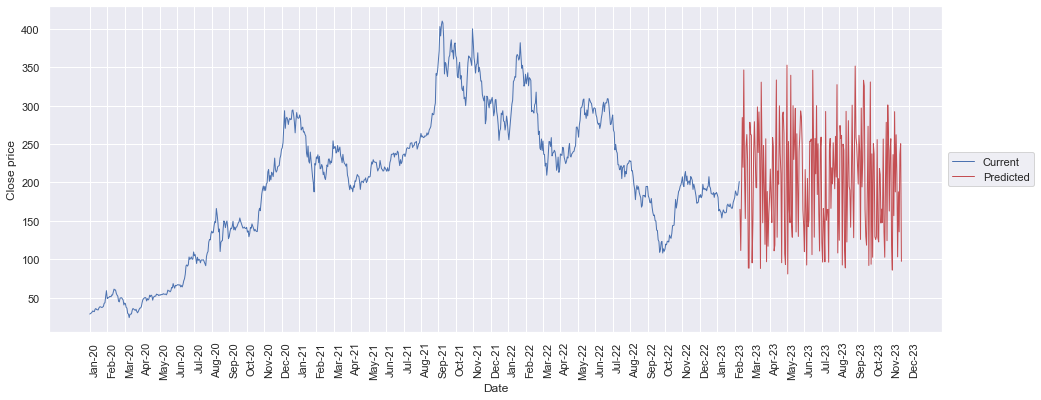

In [188]:
tesla_range = 858
plt.figure(figsize=(16, 6))
ticks = pd.date_range(start='2020-01-01', end='2023-12-31', freq='M')
plt.plot(range(tesla_range), tesla1.Close[:-214], 'b', linewidth=1, label='Current')
plt.plot(range(tesla_range, len(tesla1[-214:])+tesla_range), tesla1.Pred_close[-214:], 'r', linewidth=1, label='Predicted')
plt.xticks(range(0, len(tesla1)+16, 23), ticks.strftime("%b-%y"), rotation=90, ha='left')
plt.xlabel('Date')
plt.ylabel('Close price')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5));